# Example of Using the Deep Compact Clustering Code

In [1]:
import os

import torch
import numpy as np
import pandas as pd
import sciplots as plots
from netloader.networks import load_net

from src.main import init
from src.utils import plot_config, utils

## Initial Setup

Most settings are controlled through the Yaml config file located at `compact_clustering_config.yaml`. \
This file can be edited to change the dataset, network architecture, training parameters, and output settings.

In [2]:
config = utils.open_config('main', os.path.join(utils.ROOT, '../compact_clustering_config.yaml'))[1]

net_epochs = config['training']['epochs']
plots_dir = str(os.path.join(utils.ROOT, config['output']['plots-directory']))
states_dir = str(os.path.join(utils.ROOT, config['output']['network-states-directory']))
known = config['training']['known']
unknown = config['training']['unknown']
plot_colours = np.array(['k'] + plot_config.DARKSKIES[:1] + plot_config.BAHAMAS_AGN + plot_config.BAHAMAS[:-2] + plot_config.DARKSKIES[-1:] + plot_config.BAHAMAS[-2:])

### Create Output Directories and Set Random Seed

In [3]:
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

if not os.path.exists(states_dir):
    os.makedirs(states_dir)

if config['training']['seed'] >= 0:
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    np.random.seed(config['training']['seed'])
    torch.manual_seed(config['training']['seed'])

## Initialize Network and Data Loaders

All the objects required for training the network are initialised using the `init` function from `src.main`. \
This includes the data loaders for training and validation, the network architecture, and the dataset object. \
The deep compact clustering class, `CompactClusterEncoder` is defined in the `clustering` module from `src.utils` which is based on `BaseNetwork` from the `netloader.networks` module in the [PyTorch Network Loader](https://github.com/EthanTreg/PyTorch-Network-Loader/) package.

In [8]:
loaders, net, dataset = init(known, config, unknown=unknown)
print(net)

Train & Validation dataloaders: 20160	5040
Architecture: CompactClusterEncoder
Description: Compact Clustering Example
Version: 3.9.4
Network: network_v10
Epoch: 0
Optimiser: AdamW
Scheduler: ReduceLROnPlateau
Args: (method: median, center_step: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], similarity_weight: 0, class_weight: 1, compact_weight: 0, distance_weight: 1, steps: 3, cluster_weight: 2.2)


## Train Network

The network is trained using the built-in training function inherited from `BaseNetwork` for 50 epochs.

In [9]:
net.training(net_epochs, loaders)

Epoch [1/50]	Training loss: 3.610e+00	Validation loss: 3.386e+00	Time: 7.1
Epoch [2/50]	Training loss: 3.435e+00	Validation loss: 3.371e+00	Time: 6.6
Epoch [3/50]	Training loss: 3.210e+00	Validation loss: 2.951e+00	Time: 6.6
Epoch [4/50]	Training loss: 2.942e+00	Validation loss: 2.844e+00	Time: 6.6
Epoch [5/50]	Training loss: 2.855e+00	Validation loss: 2.767e+00	Time: 6.7
Epoch [6/50]	Training loss: 2.812e+00	Validation loss: 2.686e+00	Time: 6.6
Epoch [7/50]	Training loss: 2.699e+00	Validation loss: 2.537e+00	Time: 6.5
Epoch [8/50]	Training loss: 2.589e+00	Validation loss: 2.458e+00	Time: 6.5
Epoch [9/50]	Training loss: 2.516e+00	Validation loss: 2.421e+00	Time: 6.7
Epoch [10/50]	Training loss: 2.486e+00	Validation loss: 2.374e+00	Time: 6.6
Epoch [11/50]	Training loss: 2.453e+00	Validation loss: 2.339e+00	Time: 6.5
Epoch [12/50]	Training loss: 2.432e+00	Validation loss: 2.320e+00	Time: 6.5
Epoch [13/50]	Training loss: 2.406e+00	Validation loss: 2.292e+00	Time: 6.6
Epoch [14/50]	Trainin

## Load Trained Network From Previous Saved State

The network is saved after each epoch during training. \
The saved network state can be loaded using the `load_net` function from the `netloader.networks` module or using `torch.load('/path/to/saved/network.pth')`. \
Due to the default behaviour requiring saved states to be loaded safely, `netloader` and `src` should be imported before loading a saved network so that the necessary classes are added to the PyTorch safe globals.

In [10]:
net = load_net(config['training']['network-save'], states_dir, config['training']['network-name'])
net

Architecture: CompactClusterEncoder
Description: Compact Clustering Example
Version: 3.9.4
Network: network_v10
Epoch: 50
Optimiser: AdamW
Scheduler: ReduceLROnPlateau
Args: (method: median, center_step: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], similarity_weight: 0, class_weight: 1, compact_weight: 0, distance_weight: 1, steps: 3, cluster_weight: 2.2)

## Plot Loss Curve

We can use several plotting classes from the `sciplots` module in the [Science Plots](https://github.com/EthanTreg/Science-Plots) package. \
One of which is the `PlotPerformance` class to plot the loss curves. \
The network saves the training and validation loss for each loss function as a dictionary at each epoch during training; therefore, we plot the total loss below.

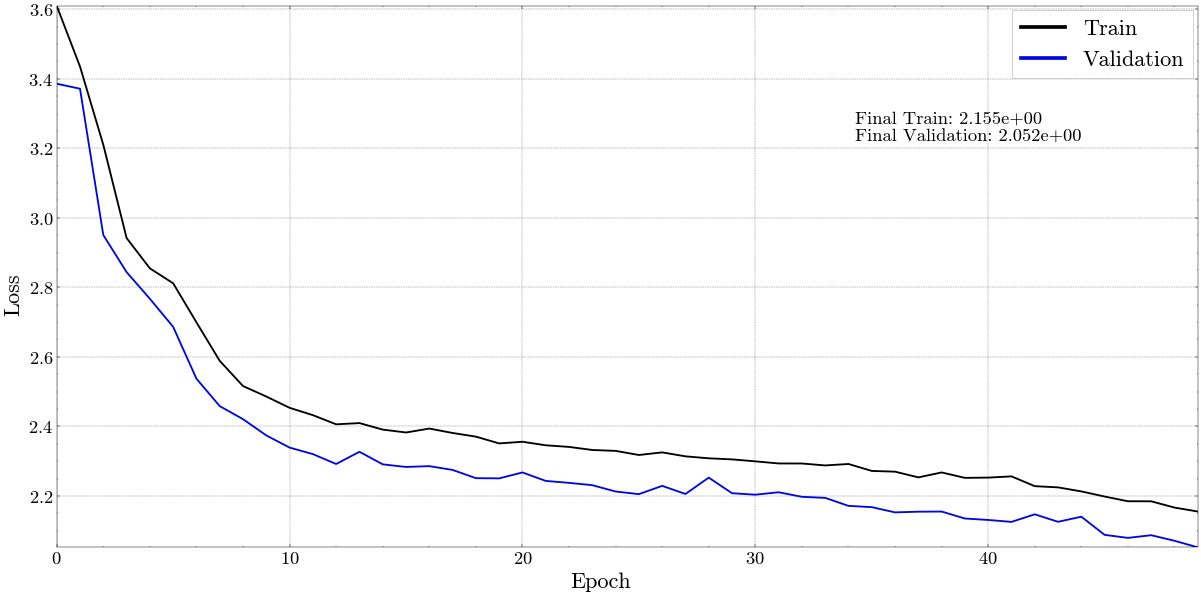

In [11]:
plots.PlotPerformance(
    np.array(net.losses) if isinstance(net.losses[0][0], float) else
    np.array([
        utils.list_dict_convert(net.losses[0])['total'],
        utils.list_dict_convert(net.losses[1])['total'],
    ]),
    log=False,
    x_label='Epoch',
    y_label='Loss',
    labels=['Train', 'Validation'],
    colours=['k', plot_config.BAHAMAS[0]],
    axis=True,
    loc='best',
    cols=1,
    fig_size=(12, 6)
)

## Generate Predictions

Predictions for a test dataset can be generated using the `predict` function inherited from `BaseNetwork`. \
This returns a dictionary containing the IDs, target classes, predicted classes, predicted class probabilities, and latent representations for each data sample. \
Because we trained with all CDM simulations having the same label, we can use the `unique_labels` function from the dataset object to map the predicted labels back to the unique simulation labels for plotting.

In [51]:
data = net.predict(loaders[1])
data['targets'] = dataset.unique_labels(
    data['targets'],
    dataset.extra['sims'].iloc[data['ids'].astype(int)],
)
data['targets'] = data['targets'].squeeze()
labels = dataset.extra['names'].to_numpy()[data['ids'][np.unique(
    data['targets'],
    return_index=True,
)[1]].astype(int)]
data.keys()

Prediction time: 2.750e+00 s


dict_keys(['ids', 'targets', 'preds', 'probs', 'latent'])

## Plot Latent Space

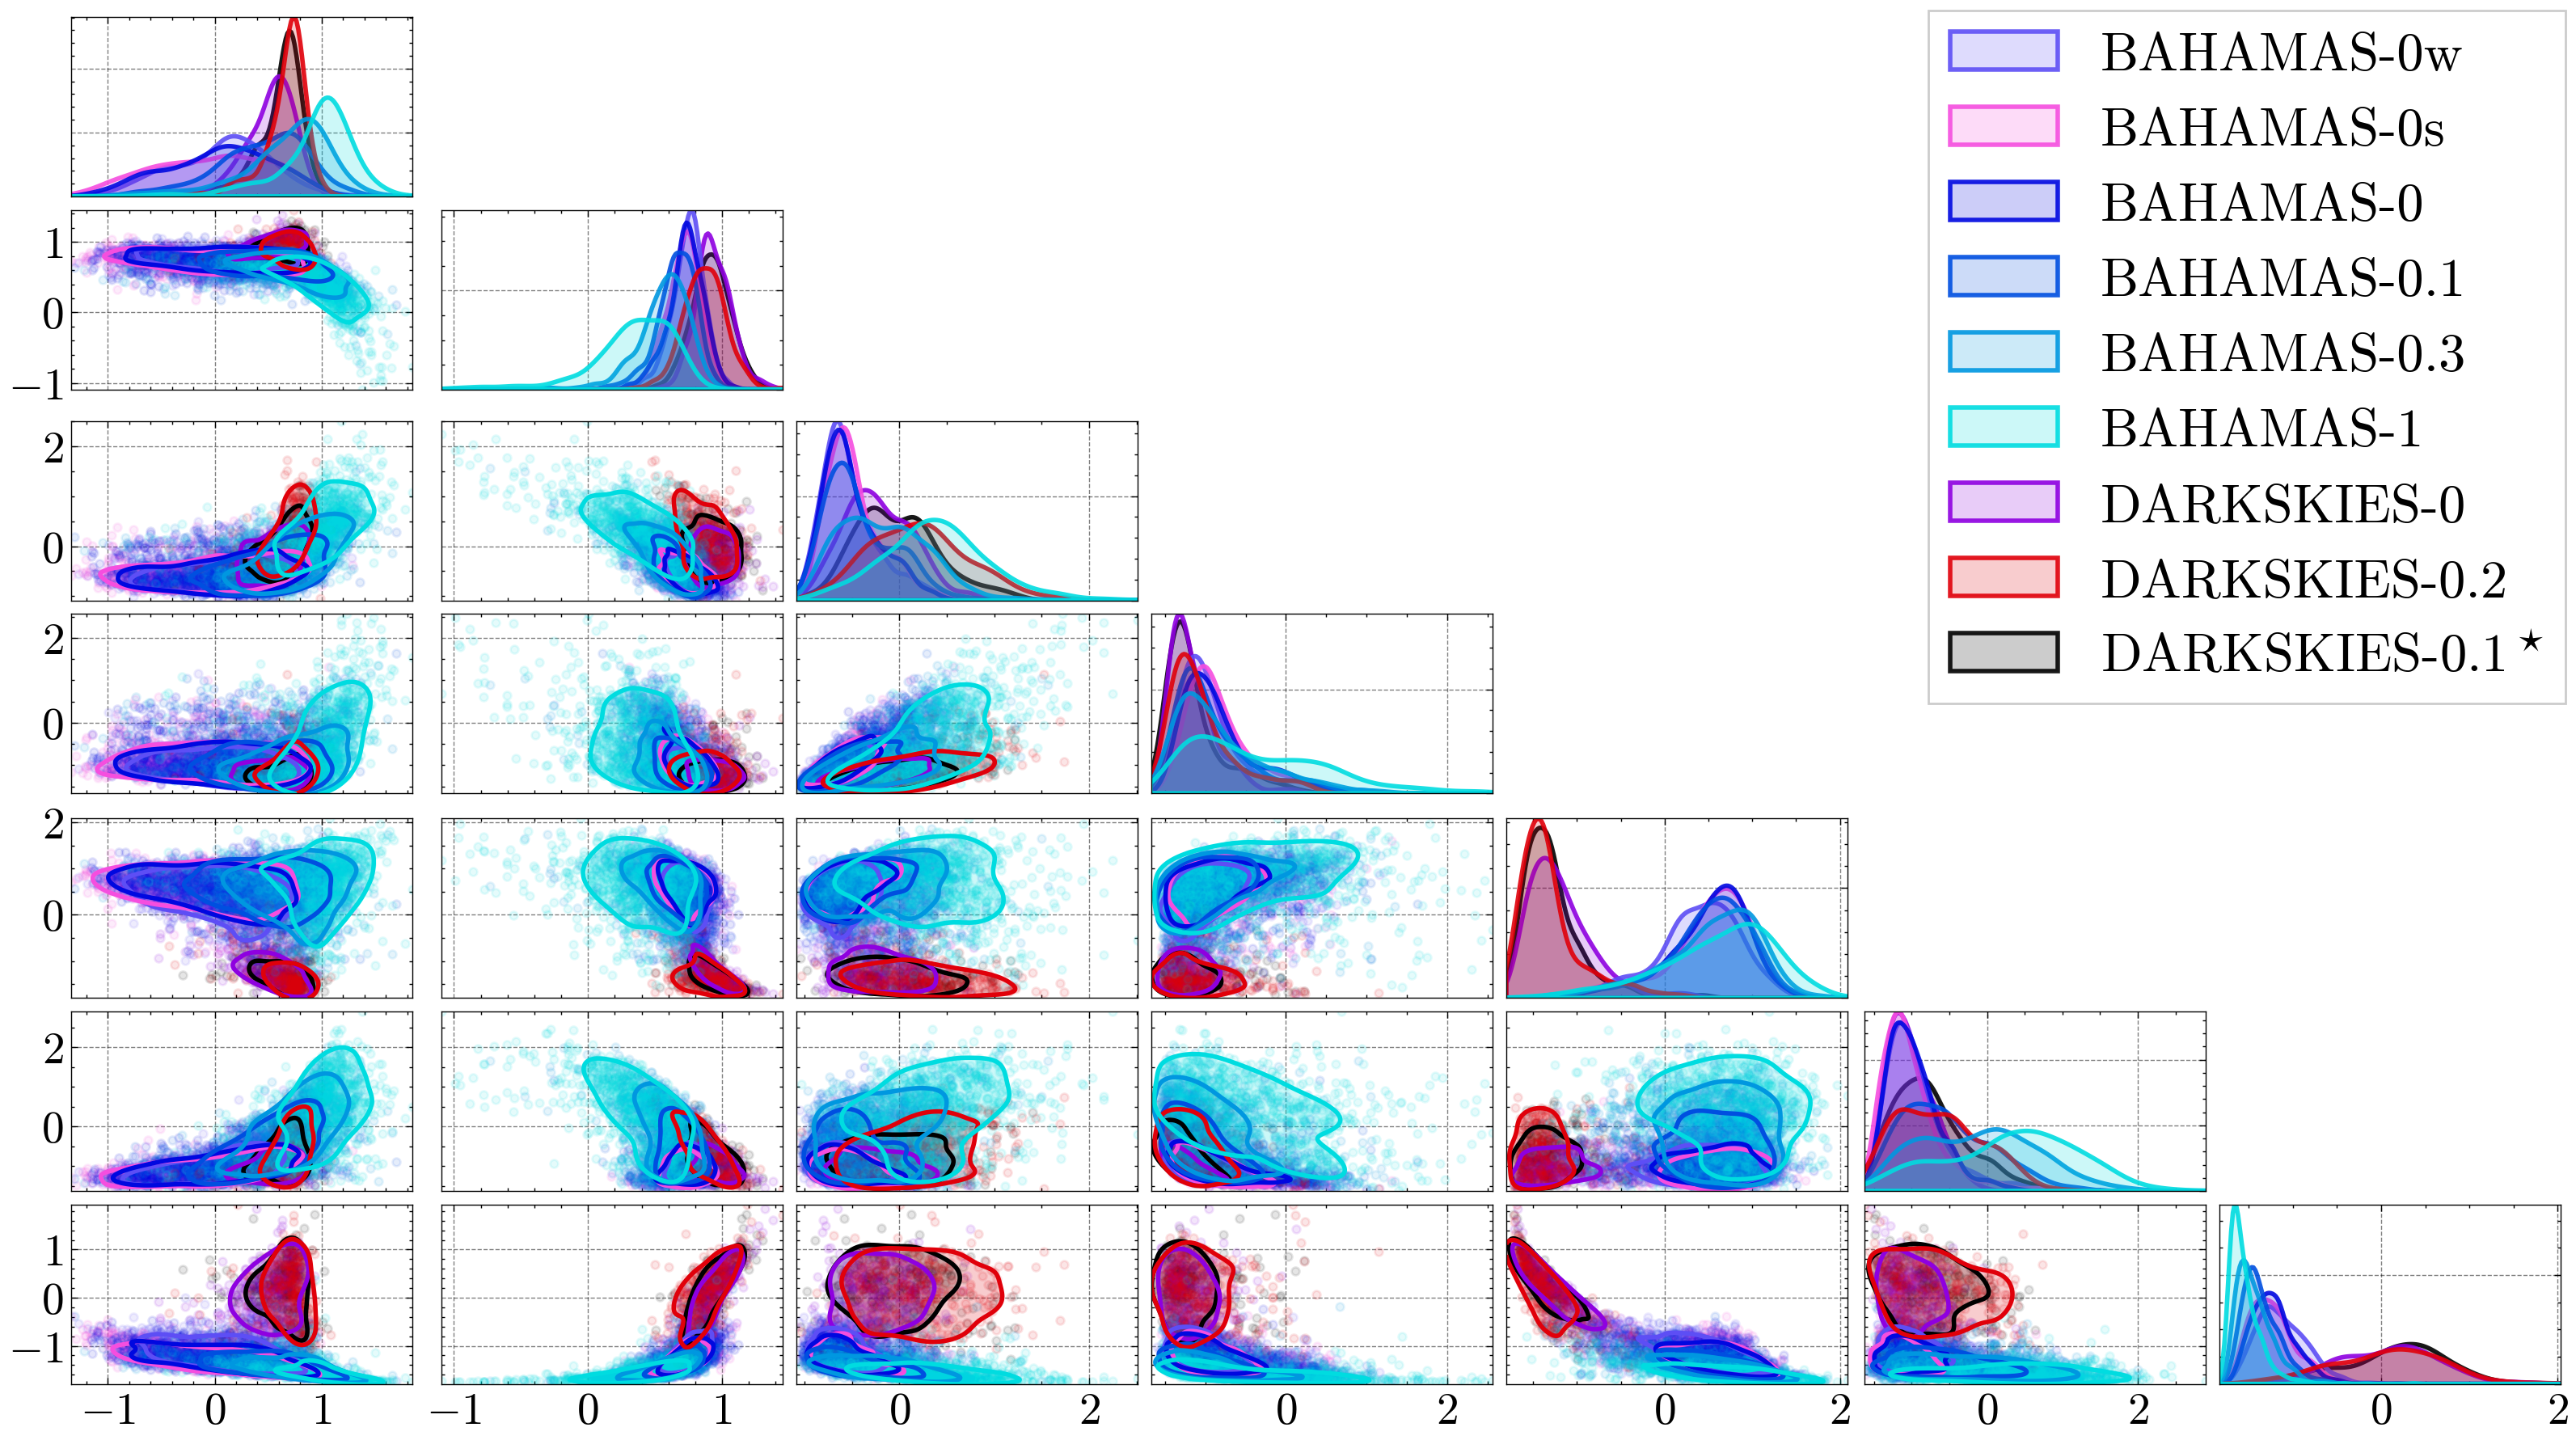

In [22]:
new_labels = labels.copy().astype(object)
new_labels[plot_colours == 'k'] = new_labels[plot_colours == 'k'] + rf'$^\star$'
label_permute = [2, 3, 4, 5, -2, -1, 1, -3, 0]
plots.PlotClusters(
    data['latent'],
    data['targets'],
    density=True,
    alpha_marker=0.1,
    alpha_2d=0.2,
    labels=new_labels,
    colours=plot_colours,
    cols=1,
    loc='upper right',
    label_permute=label_permute,
)

## Calculate Class Median, Quantiles, & Distributions for σ/m

In [23]:
sim_dists = []
medians = []
quantiles = []

for target in np.unique(data['targets']):
    idxs = data['targets'] == target
    sim_dists.append(net.transforms['targets'](data['latent'][idxs, 0], back=True))
    medians.append(np.median(data['latent'][idxs, 0]))
    quantiles.append(np.percentile(data['latent'][idxs, 0], [16, 84]))

medians = net.transforms['targets'](np.stack(medians), back=True)
quantiles = net.transforms['targets'](np.stack(quantiles), back=True)
medians.shape, quantiles.shape

((9,), (9, 2))

## Plot σ/m Distributions

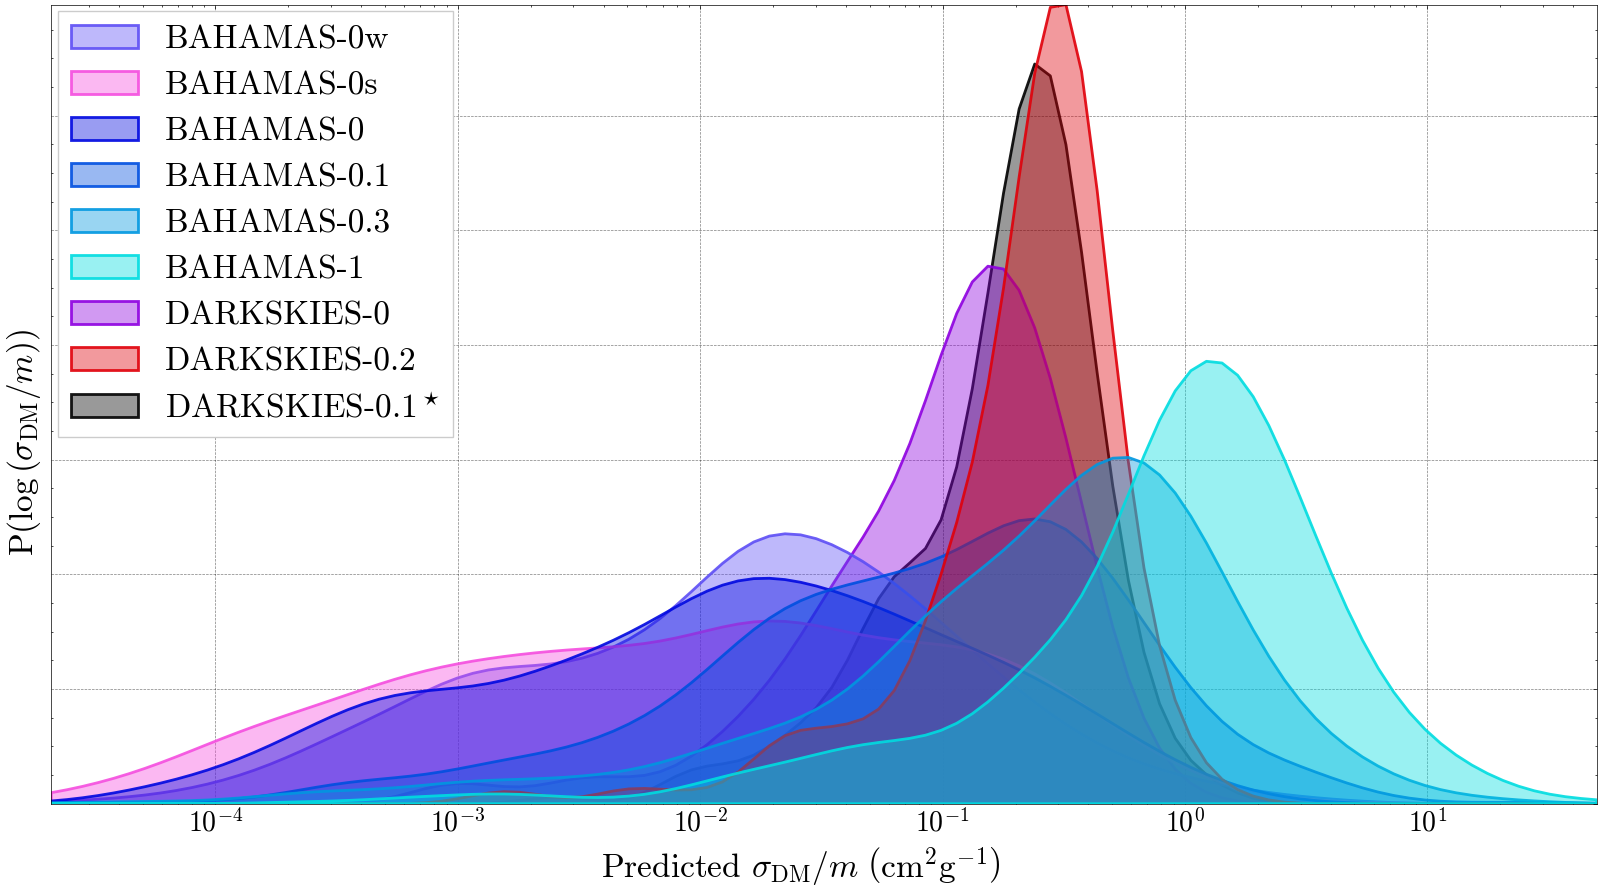

In [24]:
plots.PlotDistribution(
    sim_dists,
    log=True,
    density=True,
    x_labels=r'Predicted $\sigma_{\rm DM}/m\ \left(\rm cm^2g^{-1}\right)$',
    y_labels=r'${\rm P}\left(\log{\left(\sigma_{\rm DM}/m\right)}\right)$',
    labels=new_labels,
    colours=plot_colours,
    label_permute=label_permute,
    axis=True,
    loc='best',
    cols=1,
)

## Display Results

In [48]:
pd.DataFrame(
    np.concat((medians[:, np.newaxis], quantiles), axis=-1)[label_permute],
    columns=['Median', '16th Percentile', '84th Percentile'],
    index=[label.replace(r'$^\star$', '*') for label in new_labels[label_permute]],
).round(3)

,Median,16th Percentile,84th Percentile
BAHAMAS-0w,0.017,0.001,0.103
BAHAMAS-0s,0.012,0.001,0.137
BAHAMAS-0,0.015,0.001,0.135
BAHAMAS-0.1,0.099,0.012,0.459
BAHAMAS-0.3,0.355,0.045,1.174
BAHAMAS-1,1.106,0.218,3.057
DARKSKIES-0,0.132,0.036,0.281
DARKSKIES-0.2,0.273,0.101,0.416
DARKSKIES-0.1*,0.218,0.068,0.364
